In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.sort_values('time')

In [17]:
data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['LVR']/data['price_dex']
data['avg_gas']    = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']
data['arb_fee']    = (np.abs(data['LVR_clean'] * data['amountUSD']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['LVR'])
data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = data['price_dex'].pct_change(1).shift(-1)*100

data['time_diff']           = data['time'].diff().dt.total_seconds().fillna(0)
data['rolling_time_span']   = data['time_diff'].rolling(window=3600, min_periods=1).sum()
data['rolling_trade_count'] = data['time'].rolling(window=3600, min_periods=1).count()
data['lambda'] = data['rolling_trade_count'] / data['rolling_time_span']
data['lambda'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()

features = ['LVR_nbtoken', 'LVR', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD', 'lambda',  'rolling_time_span', 'amountUSD']
target = 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

f_min = 0.01
f_max = 0.1
w     = 0.04
k     = 1.75  # Steepness of the curve

params = {}
for f in features:
    params[f] = {'f_min': f_min, 'f_max': f_max, 'k': k, 'x0': (f_max-f_min)/(2*w)}
    
    
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,arb_fee,LVR_zscore,std,mean_rol_amount,rol_amountUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,57.565562,-0.015658,4.766625,31679.388299,3.274054e+06,-0.009999,1404.0,100.0,0.071225,0.519501
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,87.929747,-0.013781,4.713025,31196.151489,3.256138e+06,0.000000,1404.0,101.0,0.071937,-0.706067
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,18.581544,-0.013851,4.655251,31203.846347,3.255538e+06,0.010000,1428.0,102.0,0.071429,-0.183706
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,75.997578,-0.014411,4.599576,20749.062023,3.232065e+06,0.000000,1476.0,103.0,0.069783,0.641063
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,76.959780,-0.013638,4.539570,20425.349686,3.231848e+06,0.000000,1500.0,104.0,0.069333,-0.646696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,5.121515,-0.014293,1.229886,18697.005457,1.080576e+06,0.000000,47268.0,3600.0,0.076161,-0.051170
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,5.114578,-0.013906,1.265223,18890.788832,1.082558e+06,0.000000,47244.0,3600.0,0.076200,-0.051101
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,0.322773,-0.013822,1.298429,19990.184415,1.018821e+06,0.070021,47256.0,3600.0,0.076181,0.003228
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,160.210113,-0.013041,1.302969,20063.044481,1.015755e+06,0.000000,47256.0,3600.0,0.076181,0.921984


In [18]:
X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

feature_importances = model.feature_importances_ / model.feature_importances_.sum()
features_importance_normalized = {feature: importance for feature, importance in zip(features, feature_importances)}

In [ ]:
from sklearn.model_selection import KFold

X = X_filtered
y = y_filtered

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

feature_importances = np.zeros((n_splits, len(features)))

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    feature_importances[fold, :] = model.feature_importances_
    fold += 1

avg_feature_importances = feature_importances.mean(axis=0)

normalized_avg_feature_importances = avg_feature_importances / avg_feature_importances.sum()

# Create a dictionary of features and their normalized average importance
features_importance_normalized_avg = {feature: importance for feature, importance in zip(features, normalized_avg_feature_importances)}
print("\nNormalized Average Feature Importances Across Folds:")
for feature, importance in features_importance_normalized_avg.items():
    print(f"{feature}: {importance:.4f}")



Normalized Average Feature Importances Across Folds:
LVR_nbtoken: 0.0745
LVR: 0.0905
std: 0.1300
mean_rol_amount: 0.0820
avg_gas: 0.2567
price_impact: 0.0172
rol_amountUSD: 0.1716
lambda: 0.0643
rolling_time_span: 0.0554
amountUSD: 0.0578


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'feature_importances' is an array with shape (n_splits, len(features))
n_splits = feature_importances.shape[0]
features = X_filtered.columns.tolist()

# Plot feature importances for each fold
fig, axes = plt.subplots(n_splits + 1, 1, figsize=(10, 5 * n_splits))  # Adjust figure size as needed

for fold in range(n_splits):
    indices = np.argsort(feature_importances[fold])
    axes[fold].barh(range(len(indices)), feature_importances[fold, indices], color='lightblue', align='center')
    axes[fold].set_yticks(range(len(indices)))
    axes[fold].set_yticklabels(np.array(features)[indices])
    axes[fold].set_title(f'Fold {fold + 1} Feature Importances')

# Plot averaged feature importances
avg_importances = feature_importances.mean(axis=0)
indices = np.argsort(avg_importances)
axes[-1].barh(range(len(indices)), avg_importances[indices], color='salmon', align='center')
axes[-1].set_yticks(range(len(indices)))
axes[-1].set_yticklabels(np.array(features)[indices])
axes[-1].set_title('Averaged Feature Importances Across Folds')

plt.tight_layout()
plt.show()


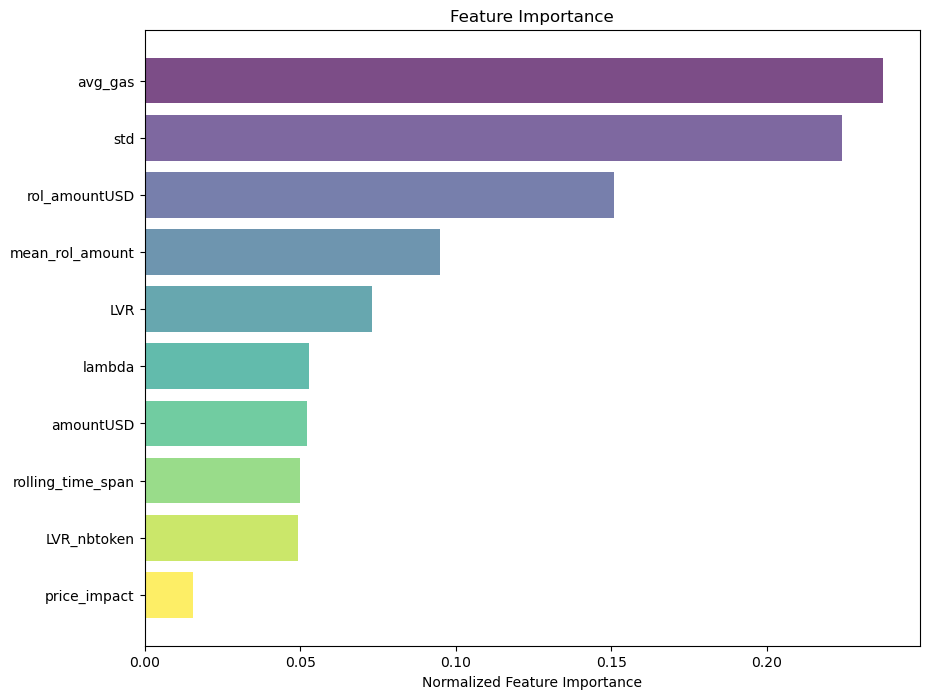

In [ ]:
features = list(features_importance_normalized.keys())
importances = list(features_importance_normalized.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color=plt.cm.viridis(np.linspace(1, 0, len(features))))
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance')
plt.show()


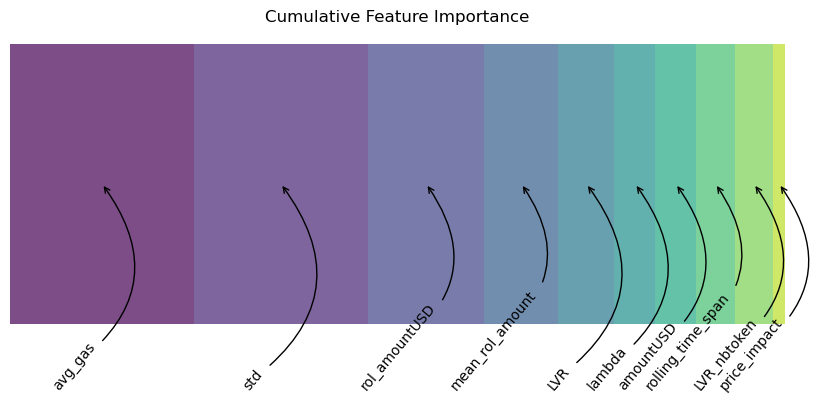

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'features_importance_normalized' is your dictionary with your features and their normalized importances
features = list(features_importance_normalized.keys())
importances = list(features_importance_normalized.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plot setup
plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
cumulative_importances = [sum(sorted_importances[:i+1]) for i in range(len(sorted_importances))]
starts = [0] + cumulative_importances[:-1]  # Starting point for each feature's bar section

# Create a stacked bar plot with annotations
for i, feature in enumerate(sorted_features):
    plt.barh(' ', sorted_importances[i], left=starts[i], color=plt.cm.viridis(i / len(sorted_features)), alpha=0.7)
    # Annotate each bar section with the feature name
    plt.annotate(feature, 
                 xy=(starts[i] + sorted_importances[i] / 2, 0), 
                 xytext=(-20, -150),  # Adjust as needed
                 textcoords="offset points",
                 ha='center', va='bottom',
                 rotation=50,  # Adjust as needed
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"))

plt.xlabel('Normalized Feature Importance')
plt.title('Cumulative Feature Importance')
plt.xlim(0, 1)  # Ensure the x-axis goes from 0 to 1 to represent the full 100% of importances
plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()


In [ ]:
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:    
    # here for each features the parameters of the sigmoid will be the one to calibrate
    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, params[f]['f_min'], params[f]['f_max'], params[f]['k'], x0))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, params[f]['f_min'], params[f]['f_max'], k, x0))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)
combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']


In [ ]:
# check the fee is correctly computed for each features
combined_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,std_weighted_fee,mean_rol_amount_weighted_fee,avg_gas_weighted_fee,price_impact_weighted_fee,rol_amountUSD_weighted_fee,lambda_weighted_fee,rolling_time_span_weighted_fee,amountUSD_weighted_fee,combined_fee,target_fee_usd
2429,111433.782726,-48.312042,111259.390272,0x675bb023e268dcc43f543620577bcacb73047f08,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,1.704113e+09,350000,3.100250e+10,3.100250e-08,...,0.013174,0.009484,0.023714,0.000329,0.015075,0.001157,0.004995,0.005231,0.074922,44699.087983
2430,1000.000000,-0.433470,998.343956,0xdf0944d413f83abeba6bc23891bc183bb9d6a77b,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704113e+09,287782,1.139920e+10,1.139920e-08,...,0.013547,0.009484,0.023714,0.000329,0.015075,0.001157,0.004995,0.005231,0.075906,410.639339
2506,1935.000000,-0.840811,1934.165416,0x00000000d7c185343e6504e428b8f8b5ad6c91b8,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,1.704114e+09,500000,1.256736e+10,1.256736e-08,...,0.018564,0.009484,0.023714,0.000329,0.015075,0.001158,0.004995,0.005231,0.080497,1553.431464
2508,570.143798,-0.247742,569.896702,0x000000422a649825bda802b2c212c46127bd96fd,0x5079fc00f00f30000e0c8c083801cfde000008b6,0x5079fc00f00f30000e0c8c083801cfde000008b6,1.704114e+09,495384,1.160238e+10,1.160238e-08,...,0.018740,0.009484,0.023714,0.000329,0.015075,0.001158,0.004995,0.005231,0.081587,398.922524
2514,2796.616640,-1.215682,2795.955783,0x8f36dc5348bf133941f07d4ea682354ca273d775,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704114e+09,442863,1.411518e+10,1.411518e-08,...,0.019460,0.009484,0.023714,0.000329,0.015075,0.001158,0.004995,0.005231,0.084373,1997.345939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57966,-18553.876823,7.500000,18553.431980,0x0e642e32974470085e362fe76de5c43330632bdb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,271927,3.329961e+10,3.329961e-08,...,-0.002296,-0.000948,-0.002371,-0.000326,-0.001507,-0.001034,-0.000499,-0.000523,-0.011276,9698.567229
57968,-15683.669136,6.340000,15683.563798,0x9ab368007a1f4c6c5bdd9cc27522f01ab6d751a8,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,356451,3.287823e+10,3.287823e-08,...,-0.002346,-0.000948,-0.002371,-0.000329,-0.001507,-0.001034,-0.000499,-0.000523,-0.011328,10416.574802
57973,-2475.266618,1.000000,2474.499118,0x2ee140fa48d3f53f8e0bb20cd1fcc11ba7178ec5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,225566,3.165331e+10,3.165331e-08,...,-0.002415,-0.000948,-0.002371,-0.000329,-0.001507,-0.001034,-0.000499,-0.000523,-0.012494,507.082893
57979,-9883.938049,3.990000,9877.063603,0xe7f525dd1bc6d748ae4d7f21d31e54741e05e110,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,234810,3.523674e+10,3.523674e-08,...,-0.002456,-0.000948,-0.002371,-0.000332,-0.001507,-0.001035,-0.000499,-0.000523,-0.011862,1011.974147


In [ ]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'LVR'                 : 'sum',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'] * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['fees_cumul'] = (metrics['volumeUSD'] * pool_fee_rate).cumsum()
metrics['avg_7m_volume'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
#metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
#metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,LVR,impermanent_loss,tcost_usd,...,cfee,dfee,cpnl,dpnl,fees_cumul,avg_7m_volume,cpnl_5m_positive,cpnl_5m_negative,dpnl_5m_positive,dpnl_5m_negative
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 14:47:00,2301.498208,2301.498208,2301.498208,2301.498208,-2760.417125,1.200000,2760.516350,-1.257850,-4.999500e-09,32.401240,...,1.380258,-41.694765,0.689947,41.004454,17.820765,2.545824,13.665011,-0.954568,1410.693837,0.0
2024-01-01 14:49:00,2300.807897,2300.807897,2300.807897,2300.807897,1806.872712,-0.784942,1806.320593,0.678315,0.000000e+00,94.660592,...,0.903160,562.139671,6.431454,567.667965,18.723925,2.510179,15.618220,-0.954568,1859.980808,0.0
2024-01-01 15:35:00,2307.951110,2307.951110,2306.336190,2306.336190,-4494.215090,1.950287,7028.246643,0.032400,-1.249875e-09,32.588830,...,3.514123,427.525011,4.206093,428.216981,22.238048,2.775653,19.824314,0.000000,2204.195769,0.0
2024-01-01 15:36:00,2306.336190,2307.028160,2306.336190,2307.028160,-5697.736609,2.471327,5694.653191,0.611470,0.000000e+00,59.234366,...,2.847327,-202.865363,5.848263,205.866299,25.085375,2.443980,25.133384,0.000000,2402.312380,0.0
2024-01-01 15:37:00,2307.720338,2310.029097,2307.720338,2310.029097,9998.888109,-4.322482,21040.459625,-4.190477,-1.249875e-08,60.034414,...,10.520230,3285.160107,10.751233,3285.391110,35.605605,3.853087,27.926990,0.000000,4528.146808,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10 18:54:00,2436.487507,2436.487507,2436.487507,2436.487507,2602.115365,-1.067107,4543.440785,0.678920,0.000000e+00,69.031420,...,2.271720,337.564493,2.271720,337.564493,47774.005041,4.625819,33.258062,0.000000,9453.459417,0.0
2024-01-10 18:55:00,2436.487507,2436.487507,2436.487507,2436.487507,-1092.613932,0.448688,1091.414847,0.265844,0.000000e+00,64.818196,...,0.545707,-25.961106,-0.185093,25.230306,47774.550748,3.188797,22.253608,-0.185093,1929.771017,0.0
2024-01-10 18:56:00,2436.487507,2436.487507,2435.756707,2435.756707,-6502.294425,2.670557,6496.245686,-1.688691,-1.124888e-08,104.580547,...,3.248123,-180.029605,3.248123,180.029605,47777.798871,3.314873,22.350963,-0.185093,2080.347304,0.0


In [ ]:
metrics['cpnl_5m_negative'].plot()
metrics['cpnl_5m_positive'].plot()

NameError: name 'metrics' is not defined

In [ ]:
metrics['dpnl_5m_negative'].plot()
metrics['dpnl_5m_positive'].plot()

0.0

In [ ]:
print(f"The total constant fees are: {round(metrics['cfee'].sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")

In [ ]:
metrics['d%_toxic_flow_ma_7m'].sum()

In [ ]:
metrics['c%_toxic_flow_ma_7m'].sum()